## Mozilla Common Voice
### ResNet50

In [ ]:
# !pip install tensorflow pandas keras matplotlib numpy scikit-learn opencv-python

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import cv2
import keras
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import Sequence
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


n_epoch = 10
batch_size = 32
image_shape = (374, 500, 3)
base_dir = "/content/drive/MyDrive/ml-project/mozilla-cv/spec/mel-mcv-train"

In [ ]:
#@title Batch Generator
class DataGenerator(Sequence):

    def __init__(self, X, y, base_dir, batch_size, n_class, shuffle=False):
        self.X = X
        self.y = y
        self.n_class = n_class
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        assert len(self.X) == len(self.y)
        return int(np.ceil(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        X_batch = self.X[index*self.batch_size : (index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size : (index+1)*self.batch_size]

        X = self.__data_generation(X_batch)
        y = keras.utils.to_categorical(y_batch, num_classes=self.n_class)
        return X, y

    def __data_generation(self, X_img):
        X = []
        for file in X_img:
            t = cv2.imread(f"{self.base_dir}/{file}", cv2.COLOR_BGR2RGB)
            X.append(t)
        return np.asarray(X)

In [ ]:
#@title Model Creation
resnet50 = tensorflow.keras.applications.resnet50.ResNet50(weights=None, input_shape=image_shape, classes=2)

model = Sequential()
model.add(resnet50)
# model.add(Dense(2, activation="softmax"))

model.build(input_shape=image_shape)
model.summary()

adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2)                 23591810  
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#@title Data Splitting
df = pd.read_csv("/content/drive/MyDrive/ml-project/mozilla-cv/spec/mel-mcv-train.csv")
print(df.shape)

X = df["imgname"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Dataset and Image Loaded")
print("X_train:", len(X_train), "\tX_test:",  len(X_test))
print("y_train:", len(y_train), "\ty_test:",  len(y_test))

(4422, 6)
Dataset and Image Loaded
X_train: 3537 	X_test: 885
y_train: 3537 	y_test: 885


In [ ]:
#@title Data Generation
train_gen = DataGenerator(X_train, y_train, base_dir=base_dir, n_class=2, batch_size=batch_size)
test_gen  = DataGenerator(X_test,  y_test,  base_dir=base_dir, n_class=2, batch_size=batch_size)

In [ ]:
#@title Model Training
for i in range(n_epoch):
    print("Epoch:", i)
    model.fit(train_gen, verbose=1)
    model.save(f"/content/drive/MyDrive/ml-project/mozilla-cv/spec/saved_model/mel_resnet50_mcv_cp_{i}", save_format="h5")

Epoch: 0
111/111 [==============================] - 663s 6s/step - loss: 0.4482 - accuracy: 0.8142
Epoch: 1
111/111 [==============================] - 54s 486ms/step - loss: 0.3040 - accuracy: 0.8917
Epoch: 2
111/111 [==============================] - 55s 494ms/step - loss: 0.2756 - accuracy: 0.9039
Epoch: 3
111/111 [==============================] - 56s 502ms/step - loss: 0.2522 - accuracy: 0.9126
Epoch: 4
111/111 [==============================] - 60s 543ms/step - loss: 0.1856 - accuracy: 0.9375
Epoch: 5
111/111 [==============================] - 61s 545ms/step - loss: 0.1749 - accuracy: 0.9378
Epoch: 6
111/111 [==============================] - 60s 535ms/step - loss: 0.1498 - accuracy: 0.9477
Epoch: 7
111/111 [==============================] - 61s 546ms/step - loss: 0.1020 - accuracy: 0.9630
Epoch: 8
111/111 [==============================] - 60s 538ms/step - loss: 0.0868 - accuracy: 0.9709
Epoch: 9
111/111 [==============================] - 61s 546ms/step - loss: 0.0583 - accuracy:

28/28 [==============================] - 179s 7s/step
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       447
           1       0.69      0.99      0.81       438

    accuracy                           0.78       885
   macro avg       0.84      0.78      0.77       885
weighted avg       0.84      0.78      0.77       885



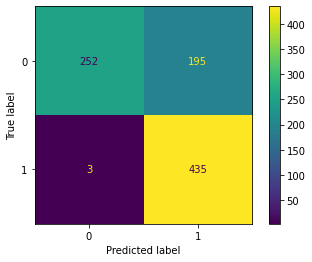

In [ ]:
#@title Model Prediction
y_pred = model.predict(test_gen)
y_pred_arg = np.argmax(y_pred, axis=1)

report = classification_report(y_true=y_test, y_pred=y_pred_arg)
print(report)

conf_mat = confusion_matrix(y_test, y_pred_arg)
conf_dis = ConfusionMatrixDisplay(conf_mat)
conf_dis.plot()
plt.show()